# Analyzing text in Ebay Auction Titles

The goal of the following code is to use language processing techniques to parse the ebay auction titles, seeing if there is any correlation between certain words and success of the auction. Another column will be added to the dataframe as "enoughKeyWords", which will be an indicator variable of whether the titles of the ebay auction contain more than 6 keywords

In [296]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import csv, json, time, sklearn
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
import re

####We first load in the data, although we are only concerned with a few of these columns

In [297]:
with open('dftouse.csv', 'r') as fd:
    dftouse = pd.read_csv(fd)


In [298]:
dftouse.head()

,Unnamed: 0,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingStatus,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ReserveMet,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength
0,0,1,131642735687,1,10590,1,False,False,0,False,41,NaN,202.09,False,2,190,Completed,1,"South Salem, New York",204.59,NaN,1,0,NaN,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,4,False,False,True,2,False,False,NaN,0,0,5,5,168
1,1,1,262126933108,1,35004,1,False,False,0,False,4,NaN,260.00,False,3,32,Completed,1,"Moody, Alabama",265.00,NaN,1,0,NaN,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,4,False,False,True,0,False,False,NaN,0,0,3,32,120
2,2,1,252155964081,1,98104,1,False,False,0,False,3,NaN,152.50,False,2,168,Completed,1,"Seattle, Washington",155.00,168534287,1,0,NaN,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120
3,3,1,252163774777,1,98104,1,False,False,0,False,1,NaN,99.00,False,2,143,Completed,1,"Seattle, Washington",100.00,168553370,1,0,NaN,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,0,False,False,True,0,False,False,NaN,0,1,2,17,120
4,4,1,252171170160,1,98104,1,False,True,0,False,5,NaN,96.00,False,2,357,Completed,1,"Seattle, Washington",97.00,168534287,1,0,NaN,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,4,False,False,False,1,False,False,NaN,0,1,2,17,120


####Time to parse the titles. This is done almost exactly like in HW5, except we want to broaden our parsing. We don't care if there are no descriptors or if we are working with pronouns. Right now, we just want to see what people have been using as ebay titles.

In [299]:
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS
import re
regex1=re.compile(r"\.{1,}")
regex2=re.compile(r"\-{1,}")

In [300]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                # this checks if token is an adjective
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    # this checks if token is in stopwords, or is a punctuation, or is a single letter
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                # anything else is considered a noun for now
                else:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    return nouns, descriptives

####Now we run get_parts on all of the titles of the auctions in our data. Let's see what we get

In [301]:
test = dftouse['Title'][0:5].map(lambda x: get_parts(x))

In [302]:
test

0    ([[iphone, 5s, 32gb, space, gray, unlock]], [[]])
1                  ([[apple, iphone, 5s, 32gb]], [[]])
2    ([[apple, iphone, 5s, 32gb, space, gray, at&t]...
3    ([[apple, iphone, 5s, 32gb, silver, verizon, s...
4    ([[apple, iphone, 5s, 32gb, space, gray, at&t]...
Name: Title, dtype: object

####At this point, we realized that what is happening in HW5 is more than what we need to work with for this project. HW5 deals with adjectives and nouns, whereas we want to see if there is any correlation with anywords given in the title. The following parses the titles for punctuation and creates a set of unique words that we will check occurances of.

In [303]:
titles = dftouse['Title'].map(lambda x: [y.lower() for y in re.split('[.,;:!?(){}`\/"@#$*|=~_ +-]',x)])

In [304]:
uniqueWords = set()
for line in titles:
    for word in line:
        # assumption here that punctuation does not affect ebay auctions
        if word not in uniqueWords:
            uniqueWords.add(word)


In [305]:
len(uniqueWords)

1326

####Next, we define a counter for occurances of the words in positive and negative responses.

In [306]:
pos_resp_count = {}
neg_resp_count = {}
dfnew = dftouse.copy()
dfnew['Title'] = titles
# create a dict with keys of unique words
for word in uniqueWords:
    pos_resp_count[word] = 0
    neg_resp_count[word] = 0

    
def pos_counter(sentence):
    for word in sentence:
        pos_resp_count[word] += 1
def neg_counter(sentence):
    for word in sentence:
        neg_resp_count[word] += 1


In [307]:
responses = dfnew['sellingStatus']
responses[:5]

0    1
1    1
2    1
3    1
4    1
Name: sellingStatus, dtype: int64

####Finally, we start counting occurances of keywords in the title.

In [308]:
for i in range(len(responses)):
    if responses[i] == 1:
        pos_counter(titles[i])
    else:
        neg_counter(titles[i])
del pos_resp_count['']
del neg_resp_count['']

####We aren't concerned about keywords that occur a few times, because they won't make a statistical difference. Instead, we define a threshold, to get a list of words that occur a significant amount of times. The threshold for negative responses is lower, since there are about half as many negative responses as positive responses.

In [309]:
new_pos = []
new_neg = []
for key in pos_resp_count.keys():
    if pos_resp_count[key] > 1000:
        new_pos.append((key,float(pos_resp_count[key])))
    if neg_resp_count[key] > 500:
        new_neg.append((key,float(neg_resp_count[key])))
new_pos.sort(key=lambda tup: tup[1])
new_neg.sort(key=lambda tup: tup[1])

keywords_pos = [x[0] for x in new_pos]

new_pos

[('factory', 1117.0),
 ('silver', 1421.0),
 ('gold', 1700.0),
 ('verizon', 1756.0),
 ('unlocked', 2132.0),
 ('at&t', 2467.0),
 ('gray', 2622.0),
 ('space', 2639.0),
 ('smartphone', 4519.0),
 ('apple', 5935.0),
 ('32gb', 6081.0),
 ('5s', 6315.0),
 ('iphone', 6344.0)]

In [310]:
keywords_pos

['factory',
 'silver',
 'gold',
 'verizon',
 'unlocked',
 'at&t',
 'gray',
 'space',
 'smartphone',
 'apple',
 '32gb',
 '5s',
 'iphone']

####The last step is to create a new column for this dataframe, and export it as a csv file

In [311]:
def countKeyWords(line):
    count = 0
    for word in line:
        if word in keywords_pos:
            count+=1
    return count


outdf = dftouse.copy()
outdf['enoughKeyWords'] = dfnew['Title'].apply(lambda x: countKeyWords(x) > 6)
outdf['enoughKeyWords'][:5]

0    False
1    False
2     True
3     True
4     True
Name: enoughKeyWords, dtype: bool

In [312]:
outdf.to_csv('dftouse_textanalysis.csv')

['factory', 'silver', 'gold', 'verizon', 'unlocked', 'at&t', 'gray', 'space', 'smartphone', 'apple', '32gb', '5s', 'iphone'] [1117.0, 1421.0, 1700.0, 1756.0, 2132.0, 2467.0, 2622.0, 2639.0, 4519.0, 5935.0, 6081.0, 6315.0, 6344.0]


([<matplotlib.axis.YTick at 0x11be73650>,
 <a list of 2 Text yticklabel objects>)

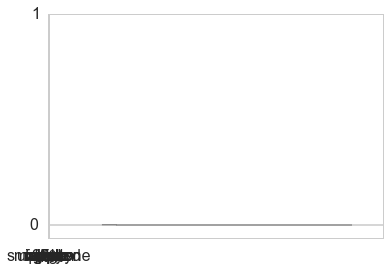

In [319]:
xvals = [x[0] for x in new_pos]
yvals = [x[1] for x in new_pos]
print xvals, yvals
plt.hist(range(len(xvals)), yvals)
plt.xticks(range(len(xvals)), xvals)
plt.yticks([0,1])